# Example CV3 - Function fitting with a quantum neural network

In this example we show how a variational circuit can be used to learn a fit for a one-dimensional function when being trained with noisy samples from that function. 

The variational circuit we use is the continuous-variable quantum neural network model described in [Killoran et al. (2018)](https://arxiv.org/abs/1806.06871). 

### Imports

We import PennyLane, the wrapped version of NumPy provided by PennyLane, and an optimizer. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

The device we use is the Strawberry Fields simulator, this time with only one quantum mode (or `wire`). You will need to have the Strawberry Fields plugin for PennyLane installed.

In [2]:
try:
    dev = qml.device('strawberryfields.fock', wires=1, cutoff_dim=10)    
except:
    print("To run this demo you need to install the strawberryfields plugin...")

### Quantum node

For a single quantum mode, each layer of the variational circuit is defined as:

In [3]:
def layer(v):

    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0., wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0., wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into the displacement of the mode, and then executes the layers. The output is the expectation of the x-quadrature.

In [4]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    
    # Encode input x into quantum state
    qml.Displacement(x, 0., wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval.X(0)

### Objective

As an objective we take the square loss between target labels and model predictions.

In [5]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l - p) ** 2
    loss = loss / len(labels)

    return loss

In the cost function, we compute the outputs from the variational circuit. Function fitting is a regression problem, and we interpret the expectations from the quantum node as predictions (i.e., without applying postprocessing such as thresholding).

In [6]:
def cost(var, features, labels):

    preds = [quantum_neural_net(var, x=x) for x in features]

    return square_loss(labels, preds)

### Optimization

We load noisy data samples of a sine function.

In [7]:
data = np.loadtxt("data/sine.txt")
X = data[:, 0]
Y = data[:, 1]

Before training a model, let's examine the data.

*Note: For the next cell to work you need the matplotlib library.* 

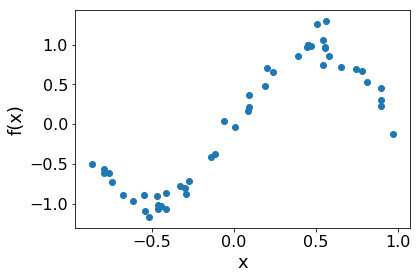

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.scatter(X, Y)
plt.xlabel('x', fontsize=18)
plt.ylabel('f(x)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.show()

The network's weights (called `var` here) are initialized with values sampled from a normal distribution. We use 4 layers; performance has been found to plateau at around 6 layers.

In [9]:
num_layers = 4
var_init = 0.05 * np.random.randn(num_layers, 7)

var_init

array([[ 0.0058762 ,  0.04570111,  0.05088388,  0.02719505, -0.0390032 ,
        -0.01649387,  0.01391179],
       [ 0.15744168, -0.00673607, -0.02268456,  0.01623216,  0.00265623,
        -0.02894138,  0.05981282],
       [-0.07003773,  0.01055664,  0.0091627 ,  0.03255751, -0.01770396,
         0.00323649,  0.04098226],
       [ 0.0044312 , -0.0512627 ,  0.06181324,  0.02483948, -0.00453443,
         0.01103624,  0.00907918],
       [-0.01946327,  0.02130946, -0.0436429 , -0.04464611,  0.03859845,
         0.01947585,  0.03514929],
       [ 0.0849767 ,  0.01599351,  0.05712417, -0.0508122 ,  0.03002098,
         0.02442569,  0.00091506]])

Using the Adam optimizer, we update the weights for 10 steps.

In [10]:
opt = AdamOptimizer(0.005, beta1=0.9, beta2=0.999)

var = var_init
for it in range(10):
    var = opt.step(lambda v: cost(v, X, Y), var)
    
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it+1, cost(var, X, Y)))

Iter:     1 | Cost: 0.3039742 
Iter:     2 | Cost: 0.2895298 
Iter:     3 | Cost: 0.2776513 
Iter:     4 | Cost: 0.2672848 
Iter:     5 | Cost: 0.2579404 
Iter:     6 | Cost: 0.2493465 
Iter:     7 | Cost: 0.2413368 
Iter:     8 | Cost: 0.2338035 
Iter:     9 | Cost: 0.2266748 
Iter:    10 | Cost: 0.2199033 


We can continue training up to 50 total steps (this takes some time).

In [11]:
for it in range(40):
    var = opt.step(lambda v: cost(v, X, Y), var)
    
    print("Iter: {:5d} | Cost: {:0.7f}".format(it+11, cost(var, X, Y)))

Iter:    11 | Cost: 0.2134581
Iter:    12 | Cost: 0.2073208
Iter:    13 | Cost: 0.2014821
Iter:    14 | Cost: 0.1959396
Iter:    15 | Cost: 0.1906959
Iter:    16 | Cost: 0.1857565
Iter:    17 | Cost: 0.1811291
Iter:    18 | Cost: 0.1768217
Iter:    19 | Cost: 0.1728416
Iter:    20 | Cost: 0.1691942
Iter:    21 | Cost: 0.1658820
Iter:    22 | Cost: 0.1629039
Iter:    23 | Cost: 0.1602542
Iter:    24 | Cost: 0.1579227
Iter:    25 | Cost: 0.1558943
Iter:    26 | Cost: 0.1541488
Iter:    27 | Cost: 0.1526620
Iter:    28 | Cost: 0.1514056
Iter:    29 | Cost: 0.1503486
Iter:    30 | Cost: 0.1494579
Iter:    31 | Cost: 0.1486997
Iter:    32 | Cost: 0.1480406
Iter:    33 | Cost: 0.1474486
Iter:    34 | Cost: 0.1468943
Iter:    35 | Cost: 0.1463518
Iter:    36 | Cost: 0.1457993
Iter:    37 | Cost: 0.1452195
Iter:    38 | Cost: 0.1445997
Iter:    39 | Cost: 0.1439322
Iter:    40 | Cost: 0.1432135
Iter:    41 | Cost: 0.1424438
Iter:    42 | Cost: 0.1416269
Iter:    43 | Cost: 0.1407690
Iter:    4

Finally, we collect the predictions of the trained model for 50 values in the range $[-1,1]$...

In [12]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

...and plot the shape of the function that the model has "learned" from the noisy data (green dots).

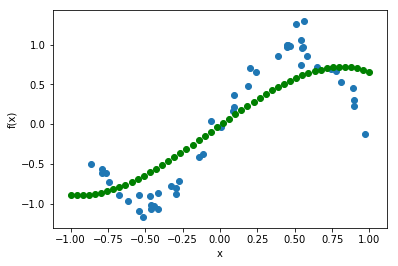

In [13]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color='green')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()

The model has learned to smooth the noisy data.

In fact, we can use PennyLane to look at typical functions that the model produces without being trained at all. The shape of these functions varies significantly with the variance hyperparameter for the weight initialization. 

Setting this hyperparameter to a small value produces almost linear functions, since all quantum gates in the variational circuit approximately perform the identity transformation in that case. Larger values produce smoothly oscillating functions with a period that depends on the number of layers used (generically, the more layers, the smaller the period).

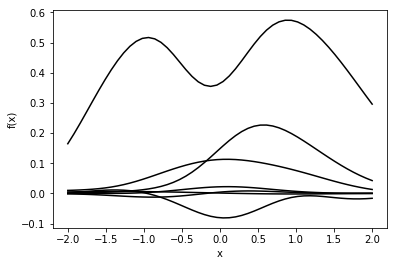

In [14]:
variance = 1.

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x=x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color='black')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()